In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz

In [2]:
df=pd.ExcelFile('D:\\Case.xlsx')
df=pd.read_excel(df,'Data')

In [3]:
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


# Statistics

In [4]:
df.describe()          #summary of data

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [5]:
df.dtypes               #all datatypes are numerical

ID                      int64
Age                     int64
Experience              int64
Income                  int64
ZIP Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal Loan           int64
Securities Account      int64
CD Account              int64
Online                  int64
CreditCard              int64
dtype: object

In [6]:
df.isna().sum()            #no imputations required

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [7]:
df.shape         #5000 datapoints with each instance having 14 columns (including ID)

(5000, 14)

# EDA

In [8]:
df.nunique()             #unique 

ID                    5000
Age                     45
Experience              47
Income                 162
ZIP Code               467
Family                   4
CCAvg                  108
Education                3
Mortgage               347
Personal Loan            2
Securities Account       2
CD Account               2
Online                   2
CreditCard               2
dtype: int64

In [9]:
len(df[df["Mortgage"]==0])     #No of people with zero mortage

3462

In [10]:
len(df[df["CCAvg"]==0] )  #No of people with zero CreditCArd spending /month

106

In [11]:
df["ZIP Code"].value_counts()     #ZIP Code value counts

94720    169
94305    127
95616    116
90095     71
93106     57
        ... 
96145      1
94970      1
94598      1
90068      1
94087      1
Name: ZIP Code, Length: 467, dtype: int64

In [12]:
df["Education"].value_counts()  #Education value counts

1    2096
3    1501
2    1403
Name: Education, dtype: int64

In [13]:
df["Personal Loan"].value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

In [14]:
df["Online"].value_counts()

1    2984
0    2016
Name: Online, dtype: int64

In [15]:
df["Securities Account"].value_counts()

0    4478
1     522
Name: Securities Account, dtype: int64

In [16]:
df['CreditCard'].value_counts()

0    3530
1    1470
Name: CreditCard, dtype: int64

In [17]:
df["CD Account"].value_counts()

0    4698
1     302
Name: CD Account, dtype: int64

In [18]:
df.drop("ID",axis=1,inplace=True)

In [19]:
df.corr()     #Correlation Matrix
            #Age and Experience are Highly correlated (one will be eliminated later to avoid multicollinearity)
            #Negative correlation indicates inverse relation 
            #Postive correlation means protional relation like between income and loan..People with higher income tend to take more loans

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
Age,1.000000,0.994215,-0.055269,-0.029216,-0.046418,-0.052030,0.041334,-0.012539,-0.007726,-0.000436,0.008043,0.013702,0.007681
Experience,0.994215,1.000000,-0.046574,-0.028626,-0.052563,-0.050089,0.013152,-0.010582,-0.007413,-0.001232,0.010353,0.013898,0.008967
Income,-0.055269,-0.046574,1.000000,-0.016410,-0.157501,0.645993,-0.187524,0.206806,0.502462,-0.002616,0.169738,0.014206,-0.002385
ZIP Code,-0.029216,-0.028626,-0.016410,1.000000,0.011778,-0.004068,-0.017377,0.007383,0.000107,0.004704,0.019972,0.016990,0.007691
Family,-0.046418,-0.052563,-0.157501,0.011778,1.000000,-0.109285,0.064929,-0.020445,0.061367,0.019994,0.014110,0.010354,0.011588
CCAvg,-0.052030,-0.050089,0.645993,-0.004068,-0.109285,1.000000,-0.136138,0.109909,0.366891,0.015087,0.136537,-0.003620,-0.006686
Education,0.041334,0.013152,-0.187524,-0.017377,0.064929,-0.136138,1.000000,-0.033327,0.136722,-0.010812,0.013934,-0.015004,-0.011014
Mortgage,-0.012539,-0.010582,0.206806,0.007383,-0.020445,0.109909,-0.033327,1.000000,0.142095,-0.005411,0.089311,-0.005995,-0.007231
Personal Loan,-0.007726,-0.007413,0.502462,0.000107,0.061367,0.366891,0.136722,0.142095,1.000000,0.021954,0.316355,0.006278,0.002802
Securities Account,-0.000436,-0.001232,-0.002616,0.004704,0.019994,0.015087,-0.010812,-0.005411,0.021954,1.000000,0.317034,0.012627,-0.015028


In [20]:
#checking for reginal effectiveness of each adv campaign, results in Personal Loan are average success rate of adv campaign
df.groupby(['ZIP Code']).mean().sort_values("Personal Loan",ascending=False).head(20) 

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ZIP Code,,,,,,,,,,,,
95135,37.000000,12.333333,100.333333,3.666667,3.200000,2.000000,222.666667,0.666667,0.000000,0.000000,0.666667,0.000000
96008,48.000000,23.333333,139.000000,3.000000,5.333333,2.000000,155.666667,0.666667,0.666667,0.666667,1.000000,0.666667
92056,44.166667,19.166667,117.166667,2.833333,4.900000,2.500000,141.166667,0.500000,0.166667,0.333333,1.000000,0.833333
94108,40.750000,15.750000,104.250000,3.250000,2.875000,2.250000,0.000000,0.500000,0.250000,0.250000,0.250000,0.750000
90016,42.000000,14.500000,75.000000,4.000000,0.450000,3.000000,0.000000,0.500000,0.000000,0.500000,0.500000,0.500000
90059,47.250000,22.500000,94.000000,2.750000,1.725000,2.000000,83.000000,0.500000,0.000000,0.000000,1.000000,0.250000
91129,47.000000,22.000000,76.500000,3.500000,1.900000,2.500000,41.000000,0.500000,0.000000,0.000000,1.000000,0.500000
94705,42.750000,17.500000,116.250000,2.250000,2.125000,1.750000,0.000000,0.500000,0.250000,0.250000,0.500000,0.750000
93022,47.400000,21.800000,89.200000,2.600000,2.300000,1.200000,24.000000,0.400000,0.000000,0.200000,0.800000,0.400000


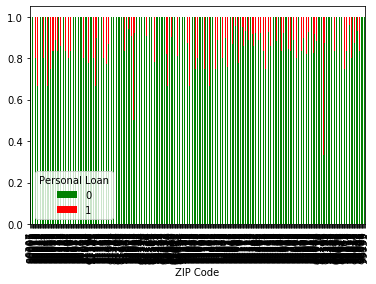

In [21]:
#graphical result of success rate of each zip code
pd.crosstab(df['ZIP Code'],df['Personal Loan'],normalize='index').plot(kind='bar',stacked=True,color=['green','red'])

In [22]:
df['ZIP Code'].describe()

df[df['ZIP Code']//10000 ==0]['ZIP Code']       #grouping by cities ,using the information in the zip code
 
df.drop(384,axis=0,inplace=True)      #Invalid zip code for USA(4 digit number), Hence row is removed

In [23]:

df["Zips"]=df['ZIP Code'].apply(lambda x: x//100)

df["Zips"].nunique()

57

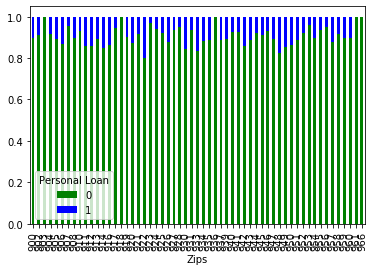

In [24]:
#success rate in cities by zipcodes
pd.crosstab(df['Zips'],df['Personal Loan'],normalize='index').plot(kind='bar',stacked=True,color=['green','blue'])

In [25]:
df.drop("Zips",axis=1,inplace=True)

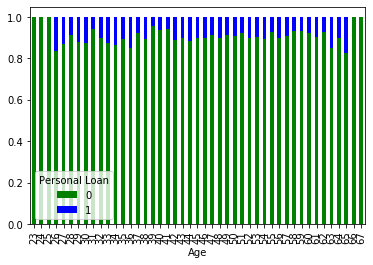

In [26]:
#Success rate by Age
pd.crosstab(df['Age'],df['Personal Loan'],normalize='index').plot(kind='bar',stacked=True,color=['green','blue'])

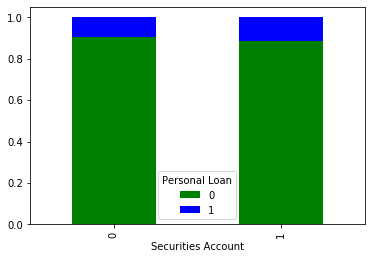

In [27]:
#sucess rate by Securities Account
pd.crosstab(df['Securities Account'],df['Personal Loan'],normalize='index').plot(kind='bar',stacked=True,color=['green','blue'])

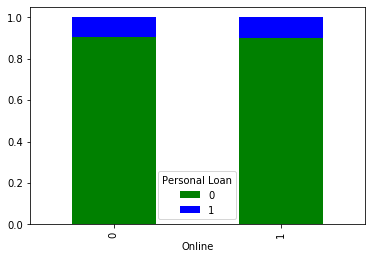

In [28]:
#sucess rate by Online  
pd.crosstab(df['Online'],df['Personal Loan'],normalize='index').plot(kind='bar',stacked=True,color=['green','blue'])

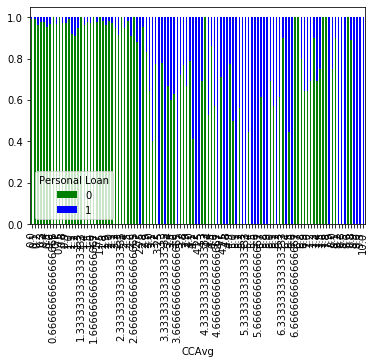

In [29]:
#sucess rate by CCAvg
pd.crosstab(df['CCAvg'],df['Personal Loan'],normalize='index').plot(kind='bar',stacked=True,color=['green','blue'])

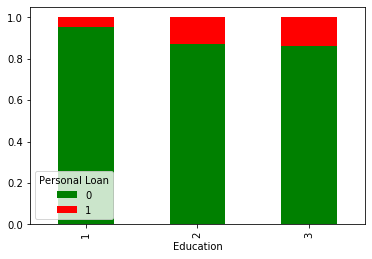

In [30]:
pd.crosstab(df['Education'],df['Personal Loan'],normalize='index').plot(kind='bar',stacked=True,color=['green','red'])

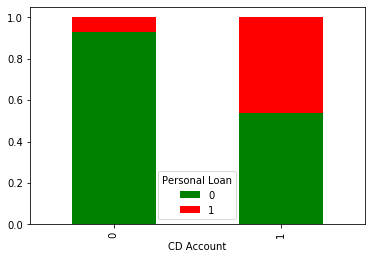

In [31]:
pd.crosstab(df['CD Account'],df['Personal Loan'],normalize='index').plot(kind='bar',stacked=True,color=['green','red'])

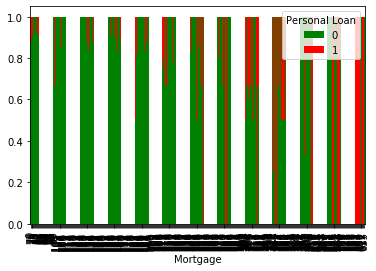

In [32]:
pd.crosstab(df['Mortgage'],df['Personal Loan'],normalize='index').plot(kind='bar',stacked=True,color=['green','red'])

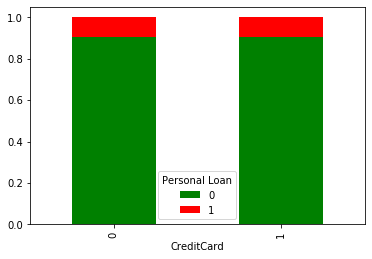

In [33]:
pd.crosstab(df['CreditCard'],df['Personal Loan'],normalize='index').plot(kind='bar',stacked=True,color=['green','red'])

In [34]:
#CHi_sqaure test to check relation with Personal Loan
def chi_square(x):
    table=pd.crosstab(df[x],df['Personal Loan']).values
#     print(table)
    stat, p, dof, expected = chi2_contingency(table)

    prob = 0.95
    critical = chi2.ppf(prob, dof)
    alpha=0.05
    if p <= alpha:
        print('Dependent (reject H0)',x,p)
    else:
        print('Independent (fail to reject H0)',x,p)

In [35]:
for x in df.columns:
    chi_square(x)

Independent (fail to reject H0) Age 0.12097935402216266
Independent (fail to reject H0) Experience 0.7042284160082671
Dependent (reject H0) Income 3.260928903025577e-269
Independent (fail to reject H0) ZIP Code 0.7512598860620401
Dependent (reject H0) Family 1.5933332069146228e-06
Dependent (reject H0) CCAvg 1.2342368608830787e-264
Dependent (reject H0) Education 6.687316745278162e-25
Dependent (reject H0) Mortgage 1.1511254565856033e-35
Dependent (reject H0) Personal Loan 0.0
Independent (fail to reject H0) Securities Account 0.1409701701771935
Dependent (reject H0) CD Account 7.913272940750307e-110
Independent (fail to reject H0) Online 0.6900723062400997
Independent (fail to reject H0) CreditCard 0.878731577532279


In [36]:
# c=",".join(list(df.columns))

# c

# with open('D:\\Web_ML\preorder_cols.txt','w') as f:
#     f.write(c)

All the Dependent Variables are statistically shown to influence Personal Loan individually, Independt ones individually do not have much influence.

Below encoding catagorical variable education,rest categorical variables being binary do not need any encoding

In [37]:
r=['Education']
ct=ColumnTransformer([('one',OneHotEncoder(),r)])
x=ct.fit_transform(df)

D:\Anaconda3\envs\py37\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [38]:
df.columns

Index(['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')

In [39]:
ct.get_feature_names()

['one__x0_1.0', 'one__x0_2.0', 'one__x0_3.0']

In [40]:
hot=pd.DataFrame(x)

hot.columns=ct.get_feature_names()
hot.head()


,one__x0_1.0,one__x0_2.0,one__x0_3.0
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


Concatonating with the main matrix df and renaming as df_n , with lengths verified at each stage and reching for nulls

In [41]:
print(len(df))
df.reset_index(inplace=True,drop=True)
print(len(df))
print(len(hot))
hot.reset_index(inplace=True,drop=True)
print(len(hot))
df_n=pd.concat([df.loc[:,:],hot],axis=1)
print(len(df_n))       
print(df_n.isna().sum())

4999
4999
4999
4999
4999
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
one__x0_1.0           0
one__x0_2.0           0
one__x0_3.0           0
dtype: int64


Zip code is dropped becuase of high sparsity,and only used in analysis of results and not predictive analysis

In [42]:
df_n.drop('Education',axis=1,inplace=True)

df_n.drop('ZIP Code',axis=1,inplace=True)

In [43]:
df_n["Prev_Association"]=df[["Securities Account","CD Account","CreditCard"]].apply(lambda x: 1 if any(x[x==1]) else 0,axis=1)

In [44]:
df_n["Prev_Association"].corr(df_n["Personal Loan"])

0.02852426361453296

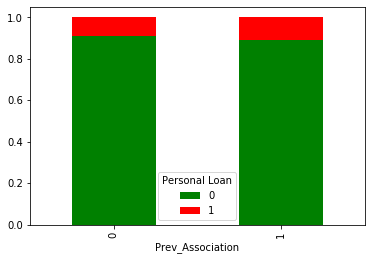

In [45]:
pd.crosstab(df_n['Prev_Association'],df_n['Personal Loan'],normalize='index').plot(kind='bar',stacked=True,color=['green','red'])

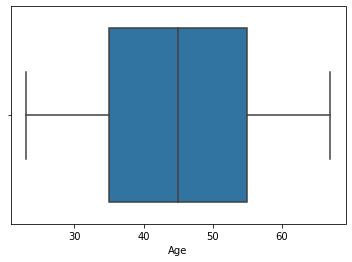

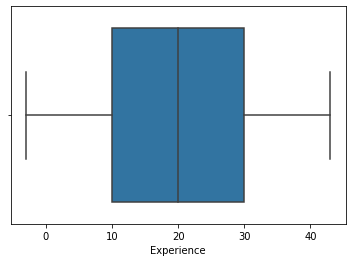

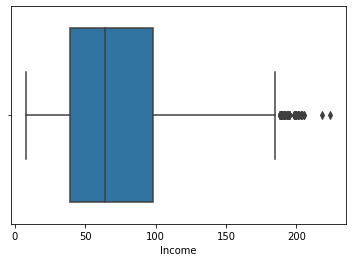

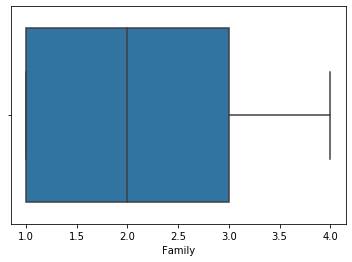

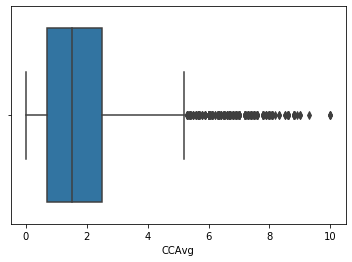

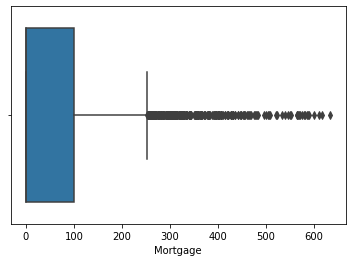

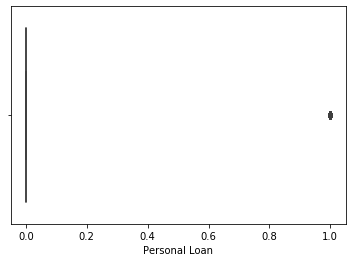

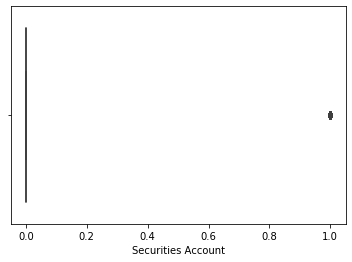

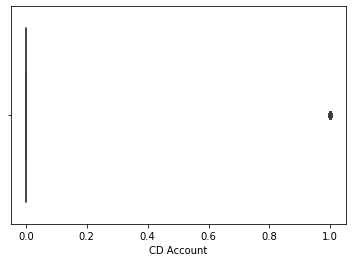

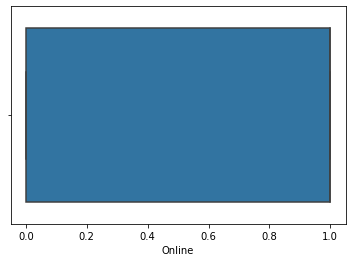

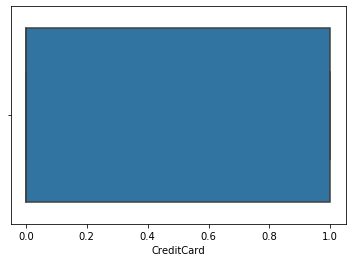

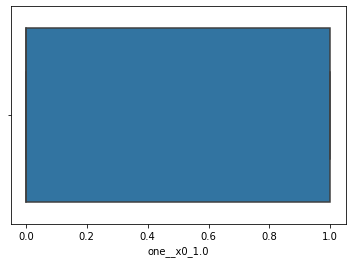

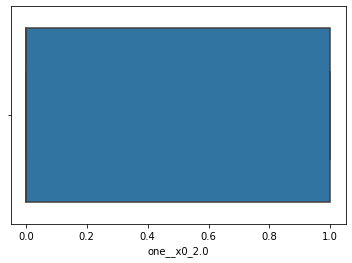

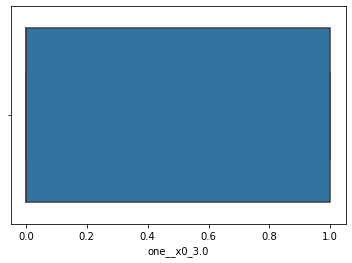

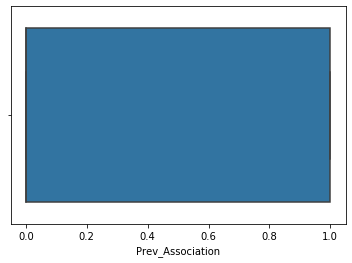

In [46]:
for i in df_n.columns:
    plt.figure()
    sns.boxplot(df_n[i])
    plt.plot()

Outlieres are Ignore because of the choice of model.(Random Forest)


In [47]:

#TO remove Outliers

# ipr= df_n.describe().loc["75%",:] -df_n.describe().loc["25%",:] 

# lb=df_n.describe().loc["25%",:]-(1.5*ipr)
# ub=df_n.describe().loc["75%",:]+(1.5*ipr)

# df_n=df_n[~((df_n<lb) |(df_n>ub))]
# df_n.dropna(axis=0,inplace=True)
# df_n.isna().sum()
# df_n.describe()

In [48]:
df_n.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,one__x0_1.0,one__x0_2.0,one__x0_3.0,Prev_Association
0,25,1,49,4,1.6,0,0,1,0,0,0,1.0,0.0,0.0,1
1,45,19,34,3,1.5,0,0,1,0,0,0,1.0,0.0,0.0,1
2,39,15,11,1,1.0,0,0,0,0,0,0,1.0,0.0,0.0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,0.0,1.0,0.0,0
4,35,8,45,4,1.0,0,0,0,0,0,1,0.0,1.0,0.0,1


Preparing Model

In [49]:
data_x=df_n.loc[:,set(df_n.columns)-set({'Personal Loan'})]
data_y=df_n["Personal Loan"]
data_x.drop(["Experience","Online","CreditCard","Securities Account"],axis=1,inplace=True)
data_x_train,data_x_test,data_y_train,data_y_test=train_test_split(data_x,data_y,test_size=0.3,random_state=7,stratify=data_y)

All Variables with even low values of chi_square test included because of working of randomForest model and also because those chi_square values are only a measure of independed influences.
Online,CreditCard,SecuritiesAccount are removed based on the feedback from feature importance order of the rf model in first Iteration.(to reduce noise)

In [50]:
data_x.columns

Index(['CD Account', 'one__x0_3.0', 'CCAvg', 'Mortgage', 'one__x0_1.0',
       'Income', 'one__x0_2.0', 'Age', 'Family', 'Prev_Association'],
      dtype='object')

# Highes Accuracy Model (Useless For Business purposes due to high FP) ,Second Column in first row..which indicates the people who were not advertised but would have taken the loan..

In [51]:
data_y.value_counts()

0    4519
1     480
Name: Personal Loan, dtype: int64

class weight is set for skewed data labels.. ratio= root(no of 1/no of zero) for Normal punishing

In [52]:
rf=RandomForestClassifier(n_estimators=200,criterion="gini",max_depth=4,class_weight={0:1,1:3.3},random_state=4,oob_score=True)
rf.fit(data_x_train,data_y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 3.3},
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=True,
                       random_state=4, verbose=0, warm_start=False)

In [53]:
print(rf.oob_score_)  #very indicative of test_error in general case



print(rf.score(data_x_train,data_y_train))

rf.score(data_x_test,data_y_test)

0.977707916547585
0.9825664475564447


0.978

# Graphical Rep of feature importance

Text(0.5, 0, 'Relative Imp')

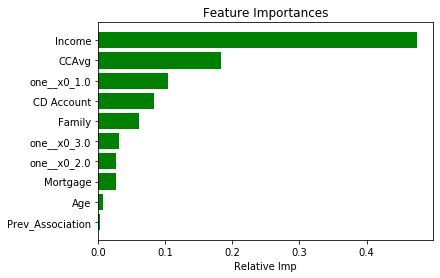

In [206]:
fi = rf.feature_importances_
ordered_fi = np.argsort(fi)
plt.figure()
plt.title('Feature Importances')
plt.barh(range(len(ordered_fi)), fi[ordered_fi], color='g', align='center')
plt.yticks(range(len(ordered_fi)), data_x.columns[ordered_fi])
plt.xlabel('Relative Imp')

## Confusion Matrix and Classification Report

In [56]:
df3=pd.DataFrame(rf.predict(data_x_test))
df3.reset_index(inplace=True,drop=True)
df3.columns=['predict']
data_y_test.reset_index(inplace=True,drop=True)

#on test set
print(classification_report(df3,data_y_test))  
print(confusion_matrix(df3,data_y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1359
           1       0.88      0.89      0.88       141

    accuracy                           0.98      1500
   macro avg       0.93      0.94      0.94      1500
weighted avg       0.98      0.98      0.98      1500

[[1341   18]
 [  15  126]]


In [58]:
roc_auc_score(df3,data_y_test)

0.9401859940820065

In [59]:
#on train set
df4=pd.DataFrame(rf.predict(data_x_train))
df4.reset_index(inplace=True,drop=True)
df4.columns=['predict']
data_y_train.reset_index(inplace=True,drop=True)


print(classification_report(df4,data_y_train))
print(confusion_matrix(df4,data_y_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3138
           1       0.95      0.88      0.91       361

    accuracy                           0.98      3499
   macro avg       0.97      0.94      0.95      3499
weighted avg       0.98      0.98      0.98      3499

[[3120   18]
 [  43  318]]


We cant allow missed oppurnity in loans..As the value of a single loan requests is much greater than few 100's of advertisements.. Hence we increase punishment on missclassified 1's (FP) to 10 (Class Weight)

# Model 2

In [60]:
rf=RandomForestClassifier(n_estimators=200,criterion="gini",max_depth=4,class_weight={0:1,1:10},random_state=4,oob_score=True)
rf.fit(data_x_train,data_y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=True,
                       random_state=4, verbose=0, warm_start=False)

In [61]:
print(rf.oob_score_)  #very indicative of test_error in general case



print(rf.score(data_x_train,data_y_train))

rf.score(data_x_test,data_y_test)

0.967705058588168
0.9711346098885396


0.9693333333333334

Text(0.5, 0, 'Relative Imp')

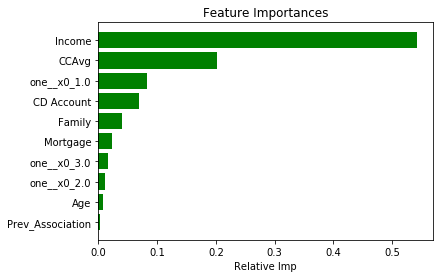

In [62]:
fi = rf.feature_importances_
ordered_fi = np.argsort(fi)
plt.figure()
plt.title('Feature Importances')
plt.barh(range(len(ordered_fi)), fi[ordered_fi], color='g', align='center')
plt.yticks(range(len(ordered_fi)), data_x.columns[ordered_fi])
plt.xlabel('Relative Imp')

In [63]:
df3=pd.DataFrame(rf.predict(data_x_test))
df3.reset_index(inplace=True,drop=True)
df3.columns=['predict']
data_y_test.reset_index(inplace=True,drop=True)

#on test set
print(classification_report(df3,data_y_test))  
print(confusion_matrix(df3,data_y_test))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1332
           1       0.92      0.79      0.85       168

    accuracy                           0.97      1500
   macro avg       0.95      0.89      0.92      1500
weighted avg       0.97      0.97      0.97      1500

[[1321   11]
 [  35  133]]


In [64]:
roc_auc_score(df3,data_y_test)

0.8917042042042042

In [65]:
df4=pd.DataFrame(rf.predict(data_x_train))
df4.reset_index(inplace=True,drop=True)
df4.columns=['predict']
data_y_train.reset_index(inplace=True,drop=True)

#on train set
print(classification_report(df4,data_y_train))
print(confusion_matrix(df4,data_y_train))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3076
           1       0.98      0.78      0.87       423

    accuracy                           0.97      3499
   macro avg       0.97      0.89      0.93      3499
weighted avg       0.97      0.97      0.97      3499

[[3069    7]
 [  94  329]]


We still have a little missed oppurtunity, 9 people in test set, 7 in train set.
Punishment is further increased for missclassifying 1's ... Class weight is increased to 20-100 range (depending on the desire to catch all loans

# Model 3

In [66]:
rf=RandomForestClassifier(n_estimators=200,criterion="gini",max_depth=3,class_weight={0:1,1:60},random_state=4,oob_score=True)
rf.fit(data_x_train,data_y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 60},
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=True,
                       random_state=4, verbose=0, warm_start=False)

In [67]:
print(rf.oob_score_)  #very indicative of test_error in general case



print(rf.score(data_x_train,data_y_train))

rf.score(data_x_test,data_y_test)

0.7730780222920834
0.7773649614175479


0.774

Text(0.5, 0, 'Relative Imp')

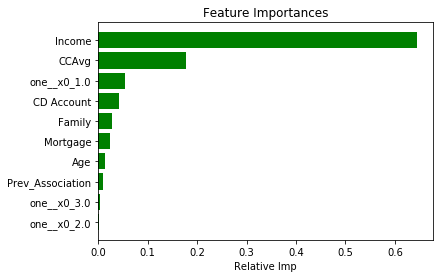

In [68]:
fi = rf.feature_importances_
ordered_fi = np.argsort(fi)
plt.figure()
plt.title('Feature Importances')
plt.barh(range(len(ordered_fi)), fi[ordered_fi], color='g', align='center')
plt.yticks(range(len(ordered_fi)), data_x.columns[ordered_fi])
plt.xlabel('Relative Imp')

In [69]:
df3=pd.DataFrame(rf.predict(data_x_test))
df3.reset_index(inplace=True,drop=True)
df3.columns=['predict']
data_y_test.reset_index(inplace=True,drop=True)

#on test set
print(classification_report(df3,data_y_test))  
print(confusion_matrix(df3,data_y_test))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      1019
           1       0.99      0.30      0.46       481

    accuracy                           0.77      1500
   macro avg       0.87      0.65      0.66      1500
weighted avg       0.83      0.77      0.73      1500

[[1018    1]
 [ 338  143]]


In [70]:
roc_auc_score(df3,data_y_test)

0.6481579715142032

In [220]:
df4=pd.DataFrame(rf.predict(data_x_train))
df4.reset_index(inplace=True,drop=True)
df4.columns=['predict']
data_y_train.reset_index(inplace=True,drop=True)

#on train set
print(classification_report(df4,data_y_train))
print(confusion_matrix(df4,data_y_train))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      2390
           1       1.00      0.30      0.47      1109

    accuracy                           0.78      3499
   macro avg       0.88      0.65      0.66      3499
weighted avg       0.83      0.78      0.74      3499

[[2390    0]
 [ 773  336]]


In [150]:
df4[df4["predict"]==1]

,predict
8,1
10,1
17,1
18,1
23,1
...,...
3464,1
3466,1
3467,1
3485,1


In [77]:
df[df['Personal Loan']==1]

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
9,34,9,180,93023,1,8.9,3,0,1,0,0,0,0
16,38,14,130,95010,4,4.7,3,134,1,0,0,0,0
18,46,21,193,91604,2,8.1,3,0,1,0,0,0,0
29,38,13,119,94104,1,3.3,2,0,1,0,1,1,1
38,42,18,141,94114,3,5.0,3,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4882,38,13,129,92646,3,4.1,3,0,1,0,1,1,1
4926,43,19,121,94720,1,0.7,2,0,1,0,1,1,1
4940,28,4,112,90049,2,1.6,2,0,1,0,0,1,0
4961,46,20,122,90065,3,3.0,3,0,1,0,1,1,1


Model 1,2,3 Can be used according to the associated costs with advetisements and the oppurtunity cost of each loan
Only Random FOrest is applied here because it is anatural choice for the way the decision process works, and the robustness of the algorithm

# Visualization of tree decision Making

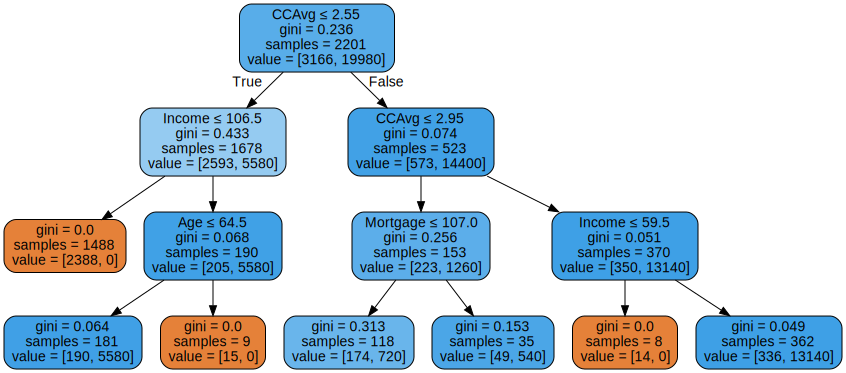

In [67]:
dot_data=tree.export_graphviz(rf[6], out_file=None,feature_names=data_x_train.columns,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data) 
graph

# Saving model for WebDeployment

In [221]:
# joblib.dump(rf,'D:\\Web_ML\Web_rf_3.joblib')


['D:\\Web_ML\\Web_rf_3.joblib']

In [69]:
list(data_x_test.columns)

['Age',
 'Prev_Association',
 'Mortgage',
 'one__x0_2.0',
 'one__x0_3.0',
 'Income',
 'CD Account',
 'one__x0_1.0',
 'Family',
 'CCAvg']

In [70]:
# c=",".join(list(data_x_test.columns))

# c

# with open('D:\\Web_ML\order_cols.txt','w') as f:
#     f.write(c)

In [71]:
# joblib.dump(ct,'D:\\Web_ML\encoder.joblib')

['D:\\Web_ML\\encoder.joblib']

In [72]:
ct.get_feature_names()

['one__x0_1.0', 'one__x0_2.0', 'one__x0_3.0']

In [76]:
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import normalize

In [77]:
data_x_normalized=normalize(data_x,norm='l2')

data_x_n=pd.DataFrame(data_x_normalized,columns=data_x.columns)

data_x_train,data_x_test,data_y_train,data_y_test=train_test_split(data_x,data_y,test_size=0.3,random_state=7,stratify=data_y)

In [96]:
lr=LogisticRegression(class_weight={0:1,1:3.3},solver="lbfgs",max_iter=2000).fit(data_x_train,data_y_train)

In [99]:
print(lr.score(data_x_test,data_y_test),"TEST Accuracy")
print(lr.score(data_x_train,data_y_train),"TRAIN Accuracy")

0.934 TEST Accuracy
0.9448413832523578 TRAIN Accuracy


In [97]:

print("TEST STATS")
print(classification_report(lr.predict(data_x_test),data_y_test))
confusion_matrix(lr.predict(data_x_test),data_y_test)

TEST STATS
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1329
           1       0.75      0.63      0.69       171

    accuracy                           0.93      1500
   macro avg       0.85      0.80      0.82      1500
weighted avg       0.93      0.93      0.93      1500



array([[1293,   36],
       [  63,  108]], dtype=int64)

In [98]:
print("TRAIN STATS")
print(classification_report(lr.predict(data_x_train),data_y_train))
confusion_matrix(lr.predict(data_x_train),data_y_train)

TRAIN STATS
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3088
           1       0.82      0.67      0.74       411

    accuracy                           0.94      3499
   macro avg       0.89      0.83      0.86      3499
weighted avg       0.94      0.94      0.94      3499



array([[3029,   59],
       [ 134,  277]], dtype=int64)

# Model 2

In [100]:
lr=LogisticRegression(class_weight="balanced",solver="lbfgs",max_iter=2000).fit(data_x_train,data_y_train)

In [101]:
print(lr.score(data_x_test,data_y_test),"TEST Accuracy")
print(lr.score(data_x_train,data_y_train),"TRAIN Accuracy")

0.9033333333333333 TEST Accuracy
0.9054015432980852 TRAIN Accuracy


In [102]:

print("TEST STATS")
print(classification_report(lr.predict(data_x_test),data_y_test))
confusion_matrix(lr.predict(data_x_test),data_y_test)

TEST STATS
              precision    recall  f1-score   support

           0       0.91      0.99      0.94      1247
           1       0.88      0.50      0.63       253

    accuracy                           0.90      1500
   macro avg       0.89      0.74      0.79      1500
weighted avg       0.90      0.90      0.89      1500



array([[1229,   18],
       [ 127,  126]], dtype=int64)

In [103]:
print("TRAIN STATS")
print(classification_report(lr.predict(data_x_train),data_y_train))
confusion_matrix(lr.predict(data_x_train),data_y_train)

TRAIN STATS
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2896
           1       0.90      0.50      0.65       603

    accuracy                           0.91      3499
   macro avg       0.91      0.75      0.80      3499
weighted avg       0.91      0.91      0.89      3499



array([[2864,   32],
       [ 299,  304]], dtype=int64)

# Model 3

In [104]:
lr=LogisticRegression(class_weight={0:1,1:60},solver="lbfgs",max_iter=2000).fit(data_x_train,data_y_train)


In [105]:
print(lr.score(data_x_test,data_y_test),"TEST Accuracy")
print(lr.score(data_x_train,data_y_train),"TRAIN Accuracy")

0.7566666666666667 TEST Accuracy
0.769648470991712 TRAIN Accuracy


In [106]:

print("TEST STATS")
print(classification_report(lr.predict(data_x_test),data_y_test))
confusion_matrix(lr.predict(data_x_test),data_y_test)

TEST STATS
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       999
           1       0.97      0.28      0.43       501

    accuracy                           0.76      1500
   macro avg       0.85      0.64      0.64      1500
weighted avg       0.81      0.76      0.71      1500



array([[995,   4],
       [361, 140]], dtype=int64)

In [107]:
print("TRAIN STATS")
print(classification_report(lr.predict(data_x_train),data_y_train))
confusion_matrix(lr.predict(data_x_train),data_y_train)

TRAIN STATS
              precision    recall  f1-score   support

           0       0.75      1.00      0.85      2367
           1       0.99      0.29      0.45      1132

    accuracy                           0.77      3499
   macro avg       0.87      0.65      0.65      3499
weighted avg       0.82      0.77      0.72      3499



array([[2362,    5],
       [ 801,  331]], dtype=int64)